In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.IterativeFitting import IterativeFitting as IF
from src.CorrFuncs import covariance_matrix, trend_est

In [3]:
study_df = pd.read_excel("SBPvPAD_data.xlsx")

In [4]:
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,1.000,1.0000,1.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,1.000,1.0000,1.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [5]:
study_df["logOR"]

0    1.000
1    0.410
2    0.440
3    1.080
4    0.230
5    1.000
6   -0.062
7    0.077
8    0.110
9    0.190
Name: logOR, dtype: float64

In [6]:
study_df.iloc[0,5:8] = np.log(study_df.iloc[0,5:8].to_numpy().astype(np.float64))
study_df.iloc[5,5:8] = np.log(study_df.iloc[5,5:8].to_numpy().astype(np.float64))
study_df

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
0,Stoekenbroek,114.0,21.000000,5428.500000,5449.5,0.000,0.0000,0.000,0.000000
1,Stoekenbroek,128.0,39.000000,5410.500000,5449.5,0.410,0.2200,0.590,0.093434
2,Stoekenbroek,139.0,51.000000,5398.500000,5449.5,0.440,0.2700,0.620,0.088384
3,Stoekenbroek,159.0,116.000000,5333.500000,5449.5,1.080,0.9900,1.170,0.045455
4,Itoga,123.9,249.666667,786.333333,1036.0,0.230,0.1600,0.310,0.037879
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [7]:
study_df_s = study_df.loc[study_df["Author"] == "Stoekenbroek"]
study_df_i = study_df.loc[study_df["Author"] == "Itoga"]
study_df_i = study_df_i.iloc[1:,:]

In [8]:
def roll_func(study_df_j,col):
    col_s_run = []
    col = study_df_j[col].to_numpy().astype(np.float64)
    for i in range(col.shape[0]-1):
        col_s_run.append(col[i+1]-col[0])
    return np.array(col_s_run)

In [9]:
dose_s_run = roll_func(study_df_j=study_df_s, col="dose")
OR_s_rise = roll_func(study_df_j=study_df_s, col="logOR")
low_s_rise = roll_func(study_df_s,"low")
high_s_rise = roll_func(study_df_s,"high")

std_s_rise = roll_func(study_df_s, "std_error")

In [10]:
log_slopes_s = OR_s_rise / dose_s_run
low_slopes_s = low_s_rise / dose_s_run
high_slopes_s = high_s_rise / dose_s_run

std_s_rise = std_s_rise / dose_s_run

In [11]:
Sigma_s = np.diag(std_s_rise)**2
inv_Sigma_s = np.linalg.inv(Sigma_s)
beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@log_slopes_s

In [12]:
low_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@low_slopes_s
high_beta_s = np.linalg.inv(np.ones((3,1)).T@inv_Sigma_s@np.ones((3,1)))@np.ones((3,1)).T@inv_Sigma_s@high_slopes_s

In [13]:
def create_covar_matrix(study_df,std_rise,Lx,dose_index=1):
    Nx_s = study_df["subjects"].to_numpy().astype(np.float64)
    Lx_s = study_df[Lx].to_numpy().astype(np.float64)[dose_index:]
    M1x_s = np.sum(study_df["cases"].to_numpy().astype(np.float64))
    A0_s = M1x_s*Nx_s[1:]/(Nx_s.sum())

    it_fit_ex = IF(Lx_s,A0_s,Nx_s,M1x_s)
    A_s, B_s, a0_s, b0_s = it_fit_ex.convexProgram()

    C = covariance_matrix(A_s,B_s,a0_s,b0_s,std_rise**2)
    inv_C = np.linalg.inv(C)

    return C, inv_C

In [14]:
C_s, inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"logOR")

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [15]:
low_C_s, low_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"low")

high_C_s, high_inv_C_s = create_covar_matrix(study_df_s,std_s_rise,"high")

In [16]:
beta_s_GL = np.linalg.inv(np.ones((3,1)).T@inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@inv_C_s@log_slopes_s
low_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@low_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@low_inv_C_s@log_slopes_s
high_beta_s_GL = np.linalg.inv(np.ones((3,1)).T@high_inv_C_s@np.ones((3,1)))@np.ones((3,1)).T@high_inv_C_s@log_slopes_s

In [17]:
beta_s_GL

array([0.02414612])

In [18]:
dose_i_run = roll_func(study_df_j=study_df_i, col="dose")
OR_i_rise = roll_func(study_df_j=study_df_i, col="logOR")
low_i_rise = roll_func(study_df_i,"low")
high_i_rise = roll_func(study_df_i,"high")

std_i_rise = roll_func(study_df_i, "std_error")

log_slopes_i = OR_i_rise / dose_i_run
low_slopes_i = low_i_rise / dose_i_run
high_slopes_i = high_i_rise / dose_i_run

std_i_rise = std_i_rise / dose_i_run

Sigma_i = np.diag(std_i_rise)**2
inv_Sigma_i = np.linalg.inv(Sigma_i)
beta_i = np.linalg.inv(np.ones((4,1)).T@inv_Sigma_i@np.ones((4,1)))@np.ones((4,1)).T@inv_Sigma_i@log_slopes_i

C_i, inv_C_i = create_covar_matrix(study_df_i,std_i_rise,"logOR")

beta_i_GL = np.linalg.inv(np.ones((4,1)).T@inv_C_i@np.ones((4,1)))@np.ones((4,1)).T@inv_C_i@log_slopes_i

In [19]:
log_slopes_i

array([-0.01291667,  0.00836957,  0.00791367,  0.00964467])

In [20]:
C_i

array([[4.46410700e-05, 1.97051483e-05, 1.62839694e-05, 9.57345970e-06],
       [1.97051483e-05, 1.68615370e-05, 1.08005842e-05, 6.34973910e-06],
       [1.62839694e-05, 9.57345970e-06, 1.16652950e-05, 5.24730674e-06],
       [1.08005842e-05, 6.34973910e-06, 5.24730674e-06, 4.74870311e-06]])

In [21]:
Sigma_i

array([[4.46410700e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.68615370e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.16652950e-05, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.74870311e-06]])

In [22]:
def slope_fn(beta,x):
    return beta*x

In [23]:
x = np.linspace(115,165)

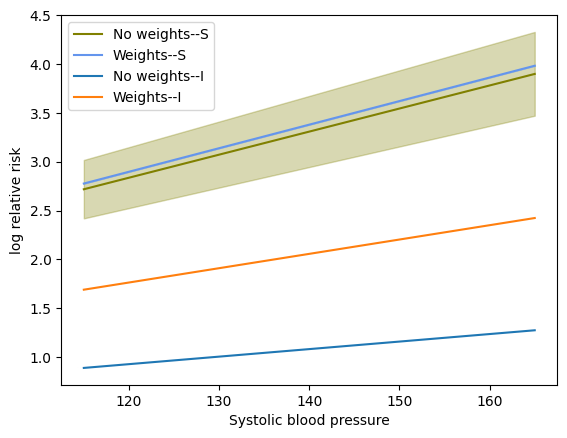

In [24]:
plt.plot(x,slope_fn(beta_s,x),label="No weights--S",c="olive")
plt.fill_between(x,slope_fn(low_beta_s,x),slope_fn(high_beta_s,x),alpha=0.3,color="olive")
plt.plot(x,slope_fn(beta_s_GL,x),label="Weights--S",c="cornflowerblue")
plt.fill_between(x,slope_fn(low_beta_s_GL,x),slope_fn(high_beta_s_GL,x),alpha=0.3,color="cornflowerblue")
plt.plot(x,slope_fn(beta_i,x),label="No weights--I")
plt.plot(x,slope_fn(beta_i_GL,x),label="Weights--I")
plt.ylabel("log relative risk")
plt.xlabel("Systolic blood pressure")
plt.legend()

#### Itoga

In [25]:
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [26]:
Nx_i = study_df_i["subjects"].to_numpy().astype(np.float64)
M1x_i = np.sum(study_df_i["cases"].to_numpy().astype(np.float64))
A0_i = M1x_i*Nx_i[1:]/(Nx_i.sum())
L_i = study_df_i["logOR"][1:].to_numpy()
L_i_p = L_i.copy()
L_i_p[0] = -0.062
x_i = study_df_i["dose"][1:].to_numpy()
x_i = x_i - 129.8
v_i = study_df_i["std_error"][1:].to_numpy()
v_ip = v_i.copy()
# v_ip[0] = 

it_fit_ex = IF(L_i_p,A0_i,Nx_i,M1x_i)
A_i, B_i, a0_i, b0_i = it_fit_ex.convexProgram()

C = covariance_matrix(A_i,B_i,a0_i,b0_i,v_ip**2)
inv_C_i = np.linalg.inv(C)

/opt/anaconda3/envs/correlationCorrection/lib/python3.12/site-packages/cvxpy/reductions/solvers/solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


In [27]:
A_i

array([213.99462598, 372.59450971, 352.59471619, 201.36317414])

In [28]:
a0_i

107.7863073121539

In [29]:
C

array([[0.00102853, 0.00087018, 0.00108647, 0.00090527],
       [0.00087018, 0.00142716, 0.00138118, 0.00115083],
       [0.00108647, 0.00090527, 0.00225385, 0.00143687],
       [0.00138118, 0.00115083, 0.00143687, 0.00184292]])

In [30]:
# Itoga corrected estimates
vb_star = 1/(np.dot(x_i,np.dot(inv_C_i,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_C_i,L_i)))

In [31]:
b_star

0.018745169004179014

In [32]:
# Itoga unadjusted estimates
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_ip)**2),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_ip)**2),L_i)))

In [33]:
b

0.0077151064467757356

There is a jump of size of order of magnitude. Why is the jump so big maybe? How do we know the difference induced by our method returns the results that are "most correct?" 

Repeat Itoga w/out negative term

In [33]:
Nx_i = study_df_i["subjects"].to_numpy().astype(np.float64)[1:]
M1x_i = np.sum(study_df_i["cases"].to_numpy().astype(np.float64)[1:])
A0_i = M1x_i*Nx_i[1:]/(Nx_i.sum())
L_i = study_df_i["logOR"][2:].to_numpy()
x_i = study_df_i["dose"][2:].to_numpy()
v_i = study_df_i["std_error"][2:].to_numpy()

it_fit_ex = IF(L_i,A0_i,Nx_i,M1x_i)
A_i, B_i, a0_i, b0_i = it_fit_ex.convexProgram()

C = covariance_matrix(A_i,B_i,a0_i,b0_i,v_i**2)
inv_C_i = np.linalg.inv(C)

In [34]:
A_i

array([322.48570552, 305.22983423, 174.39182048])

In [35]:
C

array([[0.00142716, 0.00110126, 0.00087457],
       [0.00110126, 0.00225385, 0.00108721],
       [0.00087457, 0.00108721, 0.00184292]])

In [36]:
C_nn = C
inv_C_nn = np.linalg.inv(C_nn)

In [37]:
vb_star = 1/(np.dot(x_i,np.dot(inv_C_nn,x_i)))
b_star = vb_star*(np.dot(x_i,np.dot(inv_C_nn,L_i)))
b_star

0.0008633607306968095

In [38]:
vb = 1/(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i**2)),x_i)))
b = vb*(np.dot(x_i,np.dot(np.linalg.inv(np.diag(v_i**2)),L_i)))
b

0.000859255738818118

Ok, so now the estimates are almost exactly the same. I really think the reason behind the jump here is the fact that we have that negative in the first non-reference exposure level. But why does that make such a big difference? I'm not entirely sure.

#### Itoga simulation

In [121]:
import pandas as pd
import statsmodels.api as sm

# Performing the Logit regression to recover the log odds ratios
cats_df = pd.DataFrame(cats_out_df,columns=["outcomes","categories"])
cats_df = pd.get_dummies(cats_df, columns=["categories"], dtype=np.float32)
cats_df["ones"] = np.ones(len(cats_df))
to_reg = cats_df.loc[:, [x for x in cats_df.columns if x not in ("outcomes", "categories_2.0")]]

results = sm.Logit(endog=cats_df["outcomes"], exog=to_reg).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.146112
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               outcomes   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39995
Method:                           MLE   Df Model:                            4
Date:                Thu, 23 May 2024   Pseudo R-squ.:                0.002329
Time:                        13:39:07   Log-Likelihood:                -5844.5
converged:                       True   LL-Null:                       -5858.1
Covariance Type:            nonrobust   LLR p-value:                 1.740e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
categories_3.0     0.0853      0.088      0.970      0.332      -0.087       0.258
categories_4.0   

Sanity check on logit, if our estimate is actually closer than unadjusted estimate

In [150]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

x = sm.add_constant(df[:,1])
results = sm.Logit(endog=df[:,0], exog=x).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.146110
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                40000
Model:                          Logit   Df Residuals:                    39998
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 May 2024   Pseudo R-squ.:                0.002343
Time:                        15:48:56   Log-Likelihood:                -5844.4
converged:                       True   LL-Null:                       -5858.1
Covariance Type:            nonrobust   LLR p-value:                 1.611e-07
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6303      0.060    -60.823      0.000      -3.747      -3.513
x1             0.0255      0.

In [57]:
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error
5,Itoga,129.8,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000
6,Itoga,134.6,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071
7,Itoga,139.0,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778
8,Itoga,143.7,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475
9,Itoga,149.5,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929


In [60]:
study_df_i["rounded_cases"] = np.round(study_df_i["cases"].to_numpy())
study_df_i["rounded_controls"] = np.round(study_df_i["controls"].to_numpy())

In [86]:
study_df_i["dose"] -= study_df_i["dose"].to_numpy()[0]
study_df_i

,Author,dose,cases,controls,subjects,logOR,low,high,std_error,rounded_cases,rounded_controls
5,Itoga,0.0,249.666667,2738.333333,2988.0,0.000,0.0000,0.000,0.000000,250.0,2738.0
6,Itoga,4.8,249.666667,6048.333333,6298.0,-0.062,-0.1500,-0.023,0.032071,250.0,6048.0
7,Itoga,9.2,249.666667,9341.333333,9591.0,0.077,0.0004,0.150,0.037778,250.0,9341.0
8,Itoga,13.9,249.666667,8543.333333,8793.0,0.110,0.0220,0.210,0.047475,250.0,8543.0
9,Itoga,19.7,249.666667,4401.333333,4651.0,0.190,0.1100,0.280,0.042929,250.0,4401.0


In [87]:
df_ref_list = []
for i in range(1,len(study_df_i)):
    df_ref_cases = np.array([[study_df_i["dose"].to_numpy()[i] for _ in range(int(study_df_i["rounded_cases"].to_numpy()[i]))],
                    [1 for _ in range(int(study_df_i["rounded_cases"].to_numpy()[i]))]]).T
    df_ref_controls = np.array([[study_df_i["dose"].to_numpy()[i] for _ in range(int(study_df_i["rounded_controls"].to_numpy()[i]))],
                    [0 for _ in range(int(study_df_i["rounded_controls"].to_numpy()[i]))]]).T
    df_ref_list.append(np.vstack((df_ref_cases,df_ref_controls)))


In [88]:
df_ref = np.vstack(df_ref_list)

In [89]:
df_ref = pd.DataFrame(df_ref, columns=["dose","outcome"])
df_ref.head()

,dose,outcome
0,4.8,1.0
1,4.8,1.0
2,4.8,1.0
3,4.8,1.0
4,4.8,1.0


In [91]:
# Step 4: Build the logistic regression model without an intercept
X = df_ref['dose']
y = df_ref['outcome']
# Add a constant column to X if needed (here we will not add it to exclude the intercept)
X = sm.add_constant(X)
logit_model = sm.Logit(y, X).fit()
# Step 5: Evaluate the model
print(logit_model.summary())
# # Optional: Make predictions
# predictions = logit_model.predict(X)
# predicted_classes = (predictions > 0.5).astype(int)
# # Optional: Print model coefficients
# print(f'Coefficient (slope) for dose: {logit_model.params["dose"]}')

Optimization terminated successfully.
         Current function value: 0.148448
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                29333
Model:                          Logit   Df Residuals:                    29331
Method:                           MLE   Df Model:                            1
Date:                Thu, 23 May 2024   Pseudo R-squ.:                0.001614
Time:                        13:33:25   Log-Likelihood:                -4354.4
converged:                       True   LL-Null:                       -4361.5
Covariance Type:            nonrobust   LLR p-value:                 0.0001752
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6289      0.084    -43.278      0.000      -3.793      -3.465
dose           0.0246      0.

In [93]:
np.exp(logit_model.params[1])

/var/folders/p0/hl6rzzgd2v5802nvrkllqms40000gp/T/ipykernel_8866/3760040021.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(logit_model.params[1])


1.0248559494152192

In [92]:
logit_model.params[1]

/var/folders/p0/hl6rzzgd2v5802nvrkllqms40000gp/T/ipykernel_8866/2289857680.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  logit_model.params[1]


0.024552065558216256